In this work autoencoder neural network architecture is applied for image compression. 

TODO

__Идеи__

* Рассмотреть задачу как классификацию битов (точнее, уровней сигнала) (чтобы были квантованные значения низкой битности)

* Добавить в скрытое представление информацию о цифре

# TODO: добавить аугментацию train-изображений

In [2]:
# imports

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from lossy_autoencoder import LossyAutoencoder
from image_dataset import ImageDataset
from trainer import train
from utils import (
    plot_dataset, plot_augmentation, plot_learning_curve, plot_data_latent_decoded
)
from pca_visualization import pca_visualization


from tqdm.notebook import tqdm
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import v2

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, transform=v2.ToTensor())
print(f"Train set size: {len(MNIST_train.targets)}")
MNIST_test = datasets.MNIST('./mnist', train=False, download=True, transform=v2.ToTensor())
print(f"Test set size: {len(MNIST_test.targets)}")

X_train = MNIST_train.data / MNIST_train.data.max()
X_test = MNIST_test.data / MNIST_train.data.max()

Train set size: 60000
Test set size: 10000


c:\Users\nazmievairat\anaconda3\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
class ImageDataset(Dataset):
    def __init__(self, x, transform=None):
        self.transform = transform
        self.x = x

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        curr_x = self.x[idx, ...]
        if self.transform:
            curr_x = self.transform(curr_x)
        return curr_x

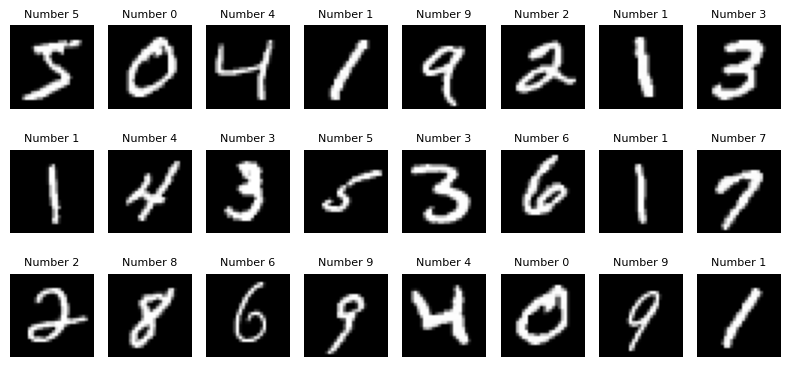

In [7]:
fig, axes = plt.subplots(ncols=8, nrows=3, figsize=(8, 4))
axes = axes.flatten()

for i, ax in enumerate(axes): 
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Number {MNIST_train.targets[i]}", fontsize=8)
    ax.set_axis_off()
    
fig.tight_layout()

## Autoencoder model

In [8]:
class LossyEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1),
            nn.PReLU(num_parameters=64),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.PReLU(num_parameters=128),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1),
            nn.PReLU(num_parameters=64),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1),
            nn.PReLU(num_parameters=32),
        )
        
    def forward(self, x):
        y = self.encoder(x)
        return y
    
    
    
class LossyDecoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.PReLU(num_parameters=32),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5),
            nn.PReLU(num_parameters=32),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=7),
            nn.PReLU(num_parameters=16),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=10),
            nn.PReLU(num_parameters=16),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5),
            nn.PReLU(num_parameters=8),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3),
            
            nn.Sigmoid()  # to fit into [0; 1]
        )
        
    def forward(self, x):
        y = self.decoder(x)
        return y
    
    
class LossyAutoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = LossyEncoder()
        self.decoder = LossyDecoder()
        
    def encode(self, x, flatten=True):
        enc = self.encoder(x)
        if flatten:
            enc = enc.flatten()
        return enc
    
    def decode(self, latent):
        return self.decoder(latent)
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        
        return reconstructed

In [9]:
lossy_autoencoder = LossyAutoencoder()
print(summary(lossy_autoencoder))

Layer (type:depth-idx)                   Param #
LossyAutoencoder                         --
├─LossyEncoder: 1-1                      --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  640
│    │    └─PReLU: 3-2                   64
│    │    └─AvgPool2d: 3-3               --
│    │    └─Conv2d: 3-4                  73,856
│    │    └─PReLU: 3-5                   128
│    │    └─AvgPool2d: 3-6               --
│    │    └─Conv2d: 3-7                  73,792
│    │    └─PReLU: 3-8                   64
│    │    └─AvgPool2d: 3-9               --
│    │    └─Conv2d: 3-10                 2,080
│    │    └─PReLU: 3-11                  32
├─LossyDecoder: 1-2                      --
│    └─Sequential: 2-2                   --
│    │    └─ConvTranspose2d: 3-12        9,248
│    │    └─PReLU: 3-13                  32
│    │    └─ConvTranspose2d: 3-14        25,632
│    │    └─PReLU: 3-15                  32
│    │    └─ConvTranspose2d: 3-16        25,104
│  

In [10]:
lossy_autoencoder.encode(X_train[0].reshape(1, 1, 28, 28)).shape

torch.Size([32])

In [11]:
lossy_autoencoder.encode(X_train[0].reshape(1, 1, 28, 28)).shape, lossy_autoencoder(X_train[0].reshape(1, 1, 28, 28)).shape

(torch.Size([32]), torch.Size([1, 1, 28, 28]))

In [12]:
# lr = 1e-4
# gamma = 0.97
# batch_size = 128
# num_epochs = 100

In [13]:
lr = 1e-3
gamma = 0.97
batch_size = 100
num_epochs = 100

In [14]:
# data augmentation
# train_transforms = v2.Compose([
#     v2.RandomAffine(degrees=25, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10, interpolation=v2.InterpolationMode.BILINEAR)
# ])
train_transforms = None

train_dataset = ImageDataset(X_train.unsqueeze(1), transform=train_transforms)
test_dataser = ImageDataset(X_test.unsqueeze(1))

In [15]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataser,
    batch_size=batch_size,
    shuffle=False
)

In [16]:
optimizer = torch.optim.Adam(params=lossy_autoencoder.parameters(), lr=lr, weight_decay=1e-6)
# loss_function = nn.BCELoss()
loss_function = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

In [17]:
def train(model, loss_function, optimizer, scheduler, train_dataloader, test_dataloader, num_epochs, device):
    loss_logs = {
        'train' : [],
        'test' : []
    }
    model.to(device)
    
    pb = tqdm(range(num_epochs))
    for epoch in pb:
        model.train()
        train_losses = []
        for x in train_dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = loss_function(y, x)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.detach().cpu().numpy())
        scheduler.step()
        
        model.eval()
        test_losses = []
        with torch.no_grad():
            for x in test_dataloader:
                x = x.to(device)
                y = model(x)
                loss = loss_function(y, x)
                
                test_losses.append(loss.detach().cpu().numpy())
                
        loss_logs['train'].append(np.mean(train_losses))
        loss_logs['test'].append(np.mean(test_losses))
        
        pb.set_postfix({'train' : loss_logs['train'][-1], 'test' : loss_logs['test'][-1]})
        
    return loss_logs

In [18]:
loss_logs = train(
    model=lossy_autoencoder,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=num_epochs,
    device=device
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
torch.save(lossy_autoencoder.state_dict(), 'lossy_conv_32.pth')

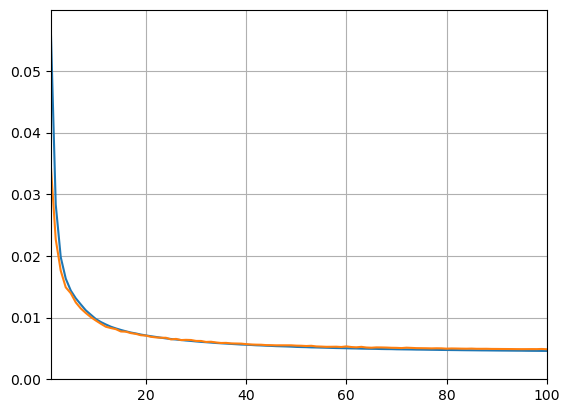

In [20]:
plt.figure()
epochs = np.arange(1, num_epochs+1)
plt.plot(epochs, loss_logs['train'])
plt.plot(epochs, loss_logs['test'])
plt.grid()
plt.xlim([1, num_epochs]); plt.ylim([0, None])
plt.show()

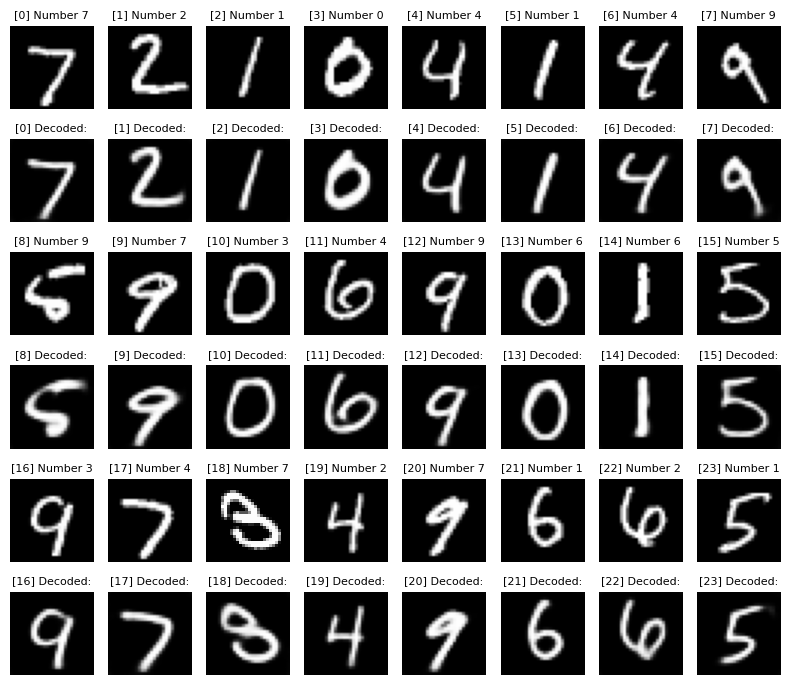

In [21]:
X_test_reconstructed = lossy_autoencoder(X_test[:24].unsqueeze(1).to(device)).detach().squeeze().cpu().numpy()


fig, axes = plt.subplots(ncols=8, nrows=6, figsize=(8, 7))
axes = axes.flatten()

img_idx = 0
rec_idx = 0
for i, ax in enumerate(axes): 
    if (i // 8) % 2 == 0:
        ax.set_title(f"[{img_idx}] Number {MNIST_test.targets[i]}", fontsize=8)
        ax.imshow(X_test[img_idx], cmap='gray')
        img_idx += 1
    else:
        ax.set_title(f"[{rec_idx}] Decoded:", fontsize=8)
        ax.imshow(X_test_reconstructed[rec_idx], cmap='gray')
        rec_idx += 1

    ax.set_axis_off()
    
fig.tight_layout()

In [22]:
X_train_latent = np.concatenate(
    [lossy_autoencoder.encode(X_train[1000*i:1000*(i+1)].unsqueeze(1).to(device), flatten=False)
     .squeeze().detach().cpu().flatten(1).numpy() for i in range(60)]
)
X_test_latent = np.concatenate(
    [lossy_autoencoder.encode(X_test[1000*i:1000*(i+1)].unsqueeze(1).to(device), flatten=False)
     .squeeze().detach().cpu().flatten(1).numpy() for i in range(10)]
)

c:\Users\nazmievairat\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


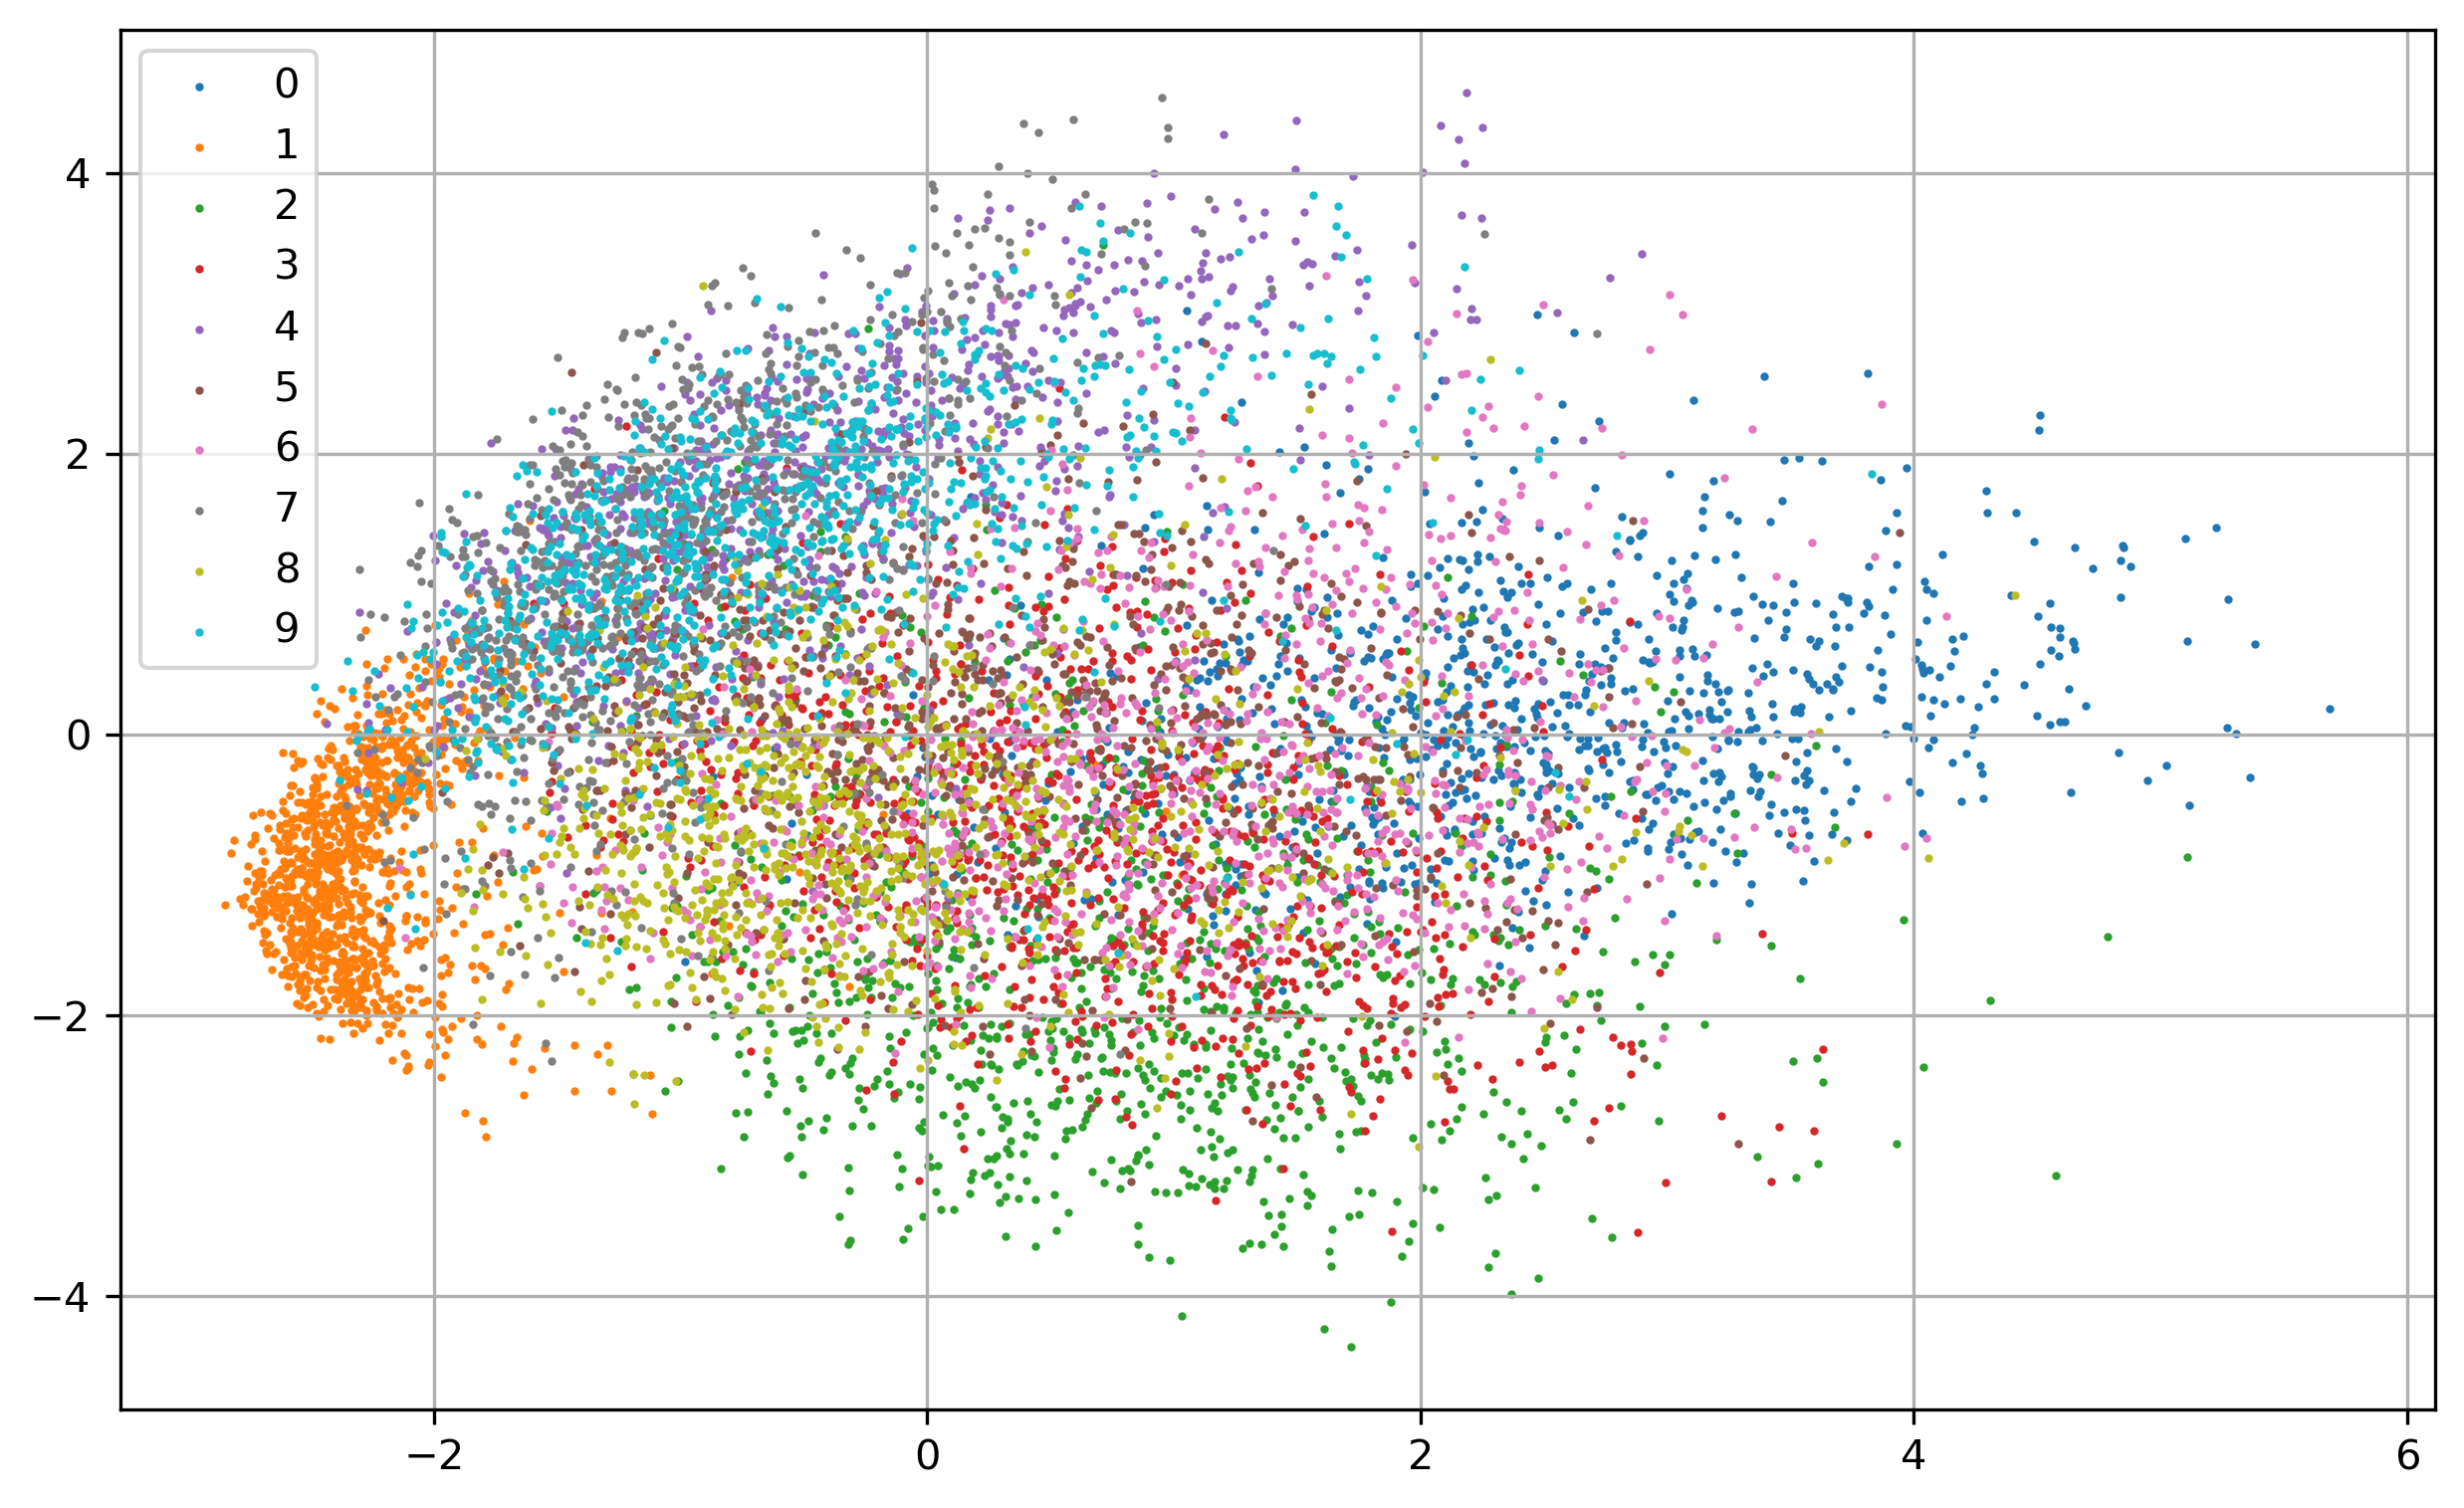

In [24]:
pca_visualization(X_train_latent, X_test_latent, MNIST_test.test_labels)